In [1]:
import plac
import spacy
model="en_core_web_sm"
nlp = spacy.load(model)

In [31]:
def filter_spans(spans):
    # Filter a sequence of spans so they don't contain overlaps
    get_sort_key = lambda span: (span.end - span.start, span.start)
    sorted_spans = sorted(spans, key=get_sort_key, reverse=True)
    result = []
    seen_tokens = set()
    for span in sorted_spans:
        if span.start not in seen_tokens and span.end - 1 not in seen_tokens:
            result.append(span)
            seen_tokens.update(range(span.start, span.end))
    return result


def extract_currency_relations(doc, ent_type="MONEY"):
    # Merge entities and noun chunks into one token
    seen_tokens = set()
    spans = list(doc.ents) + list(doc.noun_chunks)
    spans = filter_spans(spans)
    with doc.retokenize() as retokenizer:
        for span in spans:
            retokenizer.merge(span)

    relations = []
    for el in doc:
        if el.ent_type_ is not None and el.ent_type_!='':
            print('--', el.ent_type_)
    for money in filter(lambda w: w.ent_type_ == ent_type, doc):
        print('**', money.text)
        if money.dep_ in ("attr", "dobj"):
            subject = [w for w in money.head.lefts if w.dep_ == "nsubj"]
            if subject:
                subject = subject[0]
                relations.append((subject, money))
            else:
                print('entity no nsubj')
        elif money.dep_ == "pobj" and money.head.dep_ == "prep":
            relations.append((money.head.head, money))
        else:
            print('skip entity dep', money.dep_)
    return relations

In [32]:
TEXTS = [
    "Net income was $9.4 million compared to the prior year of $2.7 million.",
    "Revenue exceeded twelve billion dollars, with a loss of $1b.",
]
for text in TEXTS:
    doc = nlp(text)
    relations = extract_currency_relations(doc, "MONEY")
    for r1, r2 in relations:
        print("{:<10}\t{}\t{}".format(r1.text, r2.ent_type_, r2.text))

-- MONEY
-- DATE
-- MONEY
** $9.4 million
** $2.7 million
Net income	MONEY	$9.4 million
the prior year	MONEY	$2.7 million
-- MONEY
-- MONEY
** twelve billion dollars
** 1b
Revenue   	MONEY	twelve billion dollars
a loss    	MONEY	1b


In [34]:
# doc = nlp('I am a student')
doc = nlp(u"Mr. Best is a student.")
ents = list(doc.ents)
print([ent.label_ for ent in ents])
relations = extract_currency_relations(doc, "PERSON")
for r1, r2 in relations:
    print("{:<10}\t{}\t{}".format(r1.text, r2.ent_type_, r2.text))

['PERSON']


In [36]:
import plac
import spacy
from sagas.nlu.spacy_helper import chunks_df, doc_df
model="en_core_web_sm"
nlp = spacy.load(model)
doc = nlp(u"Mr. Best is a university student.")
chunks_df(doc)

,head,root_dep,root_text,text
0,is,nsubj,Best,Mr. Best
1,is,attr,student,a university student


In [37]:
doc=nlp("Net income was $9.4 million compared to the prior year of $2.7 million.")
chunks_df(doc)

,head,root_dep,root_text,text
0,was,nsubj,income,Net income
1,to,pobj,year,the prior year


In [38]:
doc=nlp('Revenue exceeded twelve billion dollars')
chunks_df(doc)

,head,root_dep,root_text,text
0,exceeded,nsubj,Revenue,Revenue
1,exceeded,dobj,dollars,twelve billion dollars


In [39]:
doc_df(doc)

,dep,lemma,pos,tag,text
0,nsubj,revenue,NOUN,NN,Revenue
1,ROOT,exceed,VERB,VBD,exceeded
2,compound,twelve,NUM,CD,twelve
3,nummod,billion,NUM,CD,billion
4,dobj,dollar,NOUN,NNS,dollars


revenue --(nsubj)--> exceed
exceed --(ROOT)--> exceed
twelve --(compound)--> billion
billion --(nummod)--> dollar
dollar --(dobj)--> exceed


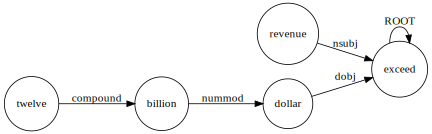

In [48]:
class SpacyViz(object):
    def __init__(self):
        from graphviz import Digraph
        self.f = Digraph('deps', filename='deps.gv')
        self.f.attr(rankdir='LR', size='6,4')
        self.f.attr('node', shape='circle')

    def print_dependencies(self, doc, segs, file=None):
        for word in doc:
            print("%s --(%s)--> %s" % (word.lemma_, word.dep_, word.head.lemma_))
            self.f.edge(word.lemma_, word.head.lemma_, label=word.dep_)

    def analyse(self, sents):
        segs = []
        doc = nlp(sents)
        for word in doc:
            self.f.node(word.lemma_)
            segs.append(word.lemma_)
        self.print_dependencies(doc, segs)
        return self.f
    
    def analyse_chunks(self, sents):
        segs = []
        doc = nlp(sents)
        print(chunks_df(doc))
        for chunk in doc.noun_chunks:
            self.f.edge(chunk.root.text, 
                        chunk.root.head.text, 
                        label=chunk.root.dep_)        
        return self.f

SpacyViz().analyse('Revenue exceeded twelve billion dollars')

       head root_dep root_text                    text
0  exceeded    nsubj   Revenue                 Revenue
1  exceeded     dobj   dollars  twelve billion dollars


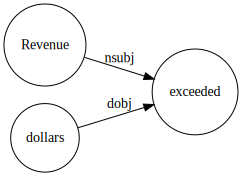

In [49]:
SpacyViz().analyse_chunks('Revenue exceeded twelve billion dollars')

  head root_dep root_text                  text
0   is    nsubj      Best              Mr. Best
1   is     attr   student  a university student


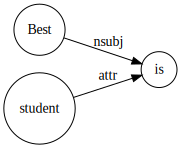

In [50]:
SpacyViz().analyse_chunks("Mr. Best is a university student.")

In [52]:
def put_chunks(doc, props):
    toks = {'text': [], 'root_text': [], 'root_dep': [], 'head': []}
    for chunk in doc.noun_chunks:
        # print(chunk.text, chunk.root.text, chunk.root.dep_,
        #      chunk.root.head.text)
        toks['text'].append(chunk.text)
        toks['root_text'].append(chunk.root.text)
        toks['root_dep'].append(chunk.root.dep_)
        toks['head'].append(chunk.root.head.text)
        props[chunk.root.dep_]=chunk.root.text
        props[chunk.root.dep_+'|text']=chunk.text
        props[chunk.root.dep_+'|head']=chunk.root.head.text
    return toks

props={}
put_chunks(doc, props)
print(json.dumps(props, indent=2))

{
  "nsubj": "Revenue",
  "nsubj|text": "Revenue",
  "nsubj|head": "exceeded",
  "dobj": "dollars",
  "dobj|text": "twelve billion dollars",
  "dobj|head": "exceeded"
}


In [55]:
import spacy
from spacy.symbols import nsubj, VERB

nlp = spacy.load("en_core_web_sm")

In [66]:
# doc = nlp(u"Autonomous cars shift insurance liability toward manufacturers")
# doc=nlp("Do you know which way to take?")
# doc=nlp("Keep an eye on my suitcase while I get my ticket.")
doc=nlp('I put on my hat')
# doc=nlp('In order to do this')
# Finding a verb with a subject from below — good
verbs = []
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.append(possible_subject.head.lemma_)
print(json.dumps(verbs))

["put"]
